In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
import cupy as cp

In [5]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/LV/data/"
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
NORM_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux.h5"
# NORM_PATH = "/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/norm/spectra.h5"
sys.path.insert(0, PROJECT_PATH)

### Load data

In [6]:
with h5py.File(NORM_PATH, 'r') as f:
    flux0 = f['flux'][()]
    para0 = f['para'][()]
    wave0 = f['wave'][()]

In [7]:
flux0.shape, wave0.shape

((116614, 15404), (15404,))

In [8]:
from lv.base.dataloader_c import DataLoader

In [9]:
ds = DataLoader()

In [10]:
ds.prepare_data (flux0, wave0, para0, "Red_M", "BHB", fix_CO=0)

Cupy flux: 3300, wave: 2204


# find masking 

In [11]:
u,w,v = ds._svd(ds.flux)

In [12]:
w[:10]

array([113.370155  ,  11.782064  ,   8.755681  ,   3.318766  ,
         1.3461212 ,   1.0364841 ,   0.8614032 ,   0.6409531 ,
         0.52222764,   0.4007302 ], dtype=float32)

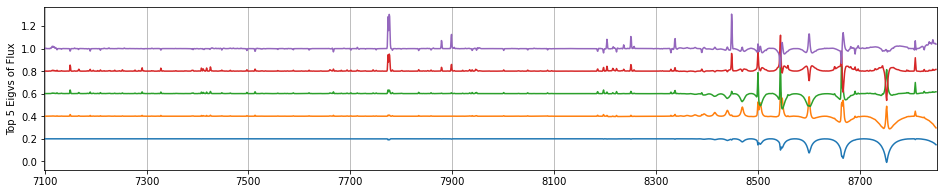

In [13]:
ds.plot_eigv(cp.asnumpy(v), name="Flux", step=0.2)

In [14]:
k,q,prom = 10, 0.6, 0.1
peaks, prop, nvv= ds.get_peaks(k=k,q=q,prom=prom)

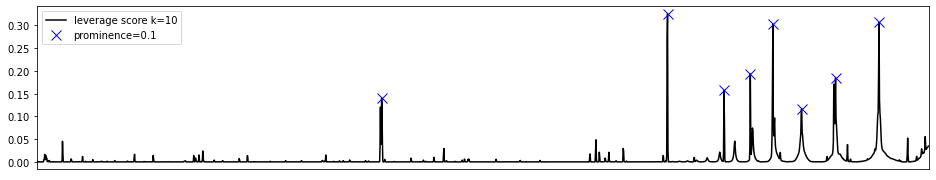

In [17]:
ds.plot_peaks(nvv, peaks, k, prom)

In [18]:
ds.get_mask_from_peaks(peaks,prop)

Text(0.5, 1.0, 'k=10, q=0.6, prom=0.1')

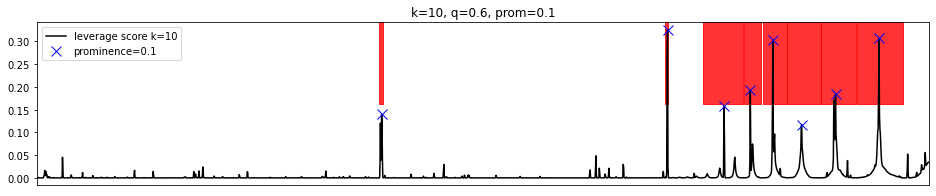

In [19]:
ds.plot_peaks(nvv, peaks, k, prom)
plt.title(f"k={k}, q={q}, prom={prom}")

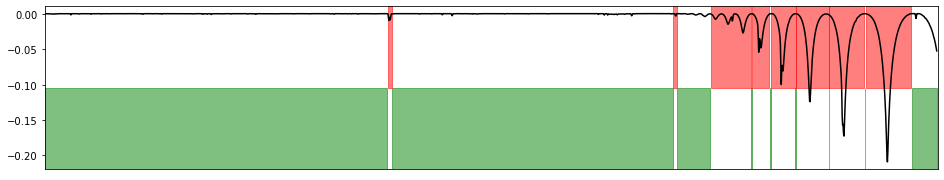

In [20]:
ds.plot_MN_mask(v[:1])

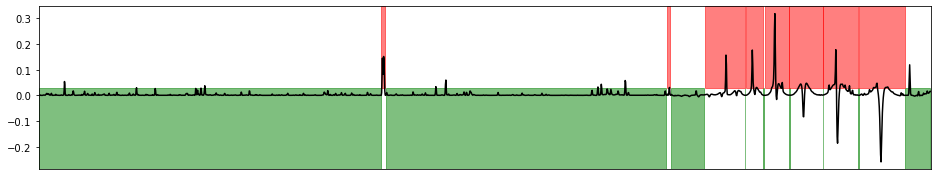

In [21]:
ds.plot_MN_mask(v[3:4])

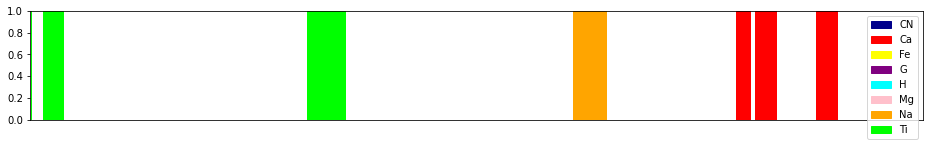

In [22]:
ds.plot_lick()

In [23]:
ds.get_MN(ds.mask, top=5)

(0.0, 1.4057623781263828)

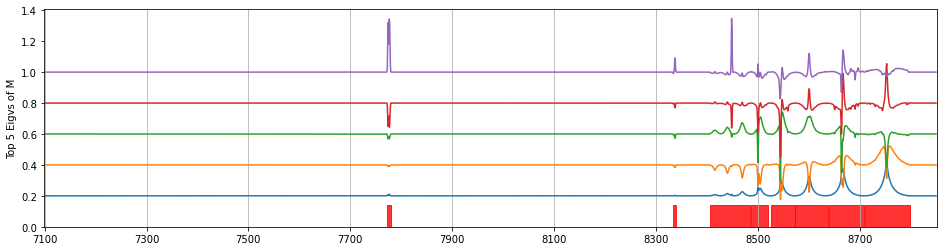

In [24]:
step = 0.2
axs = plt.subplots(1,figsize=(16,4))[1]
ds.plot_eigv(ds.Mv, mask=None, name="M", step=step, ax=axs)
ds.plot_masked(ax=axs, ymin=0, ymax=0.1)
axs.set_ylim(0.0, None)

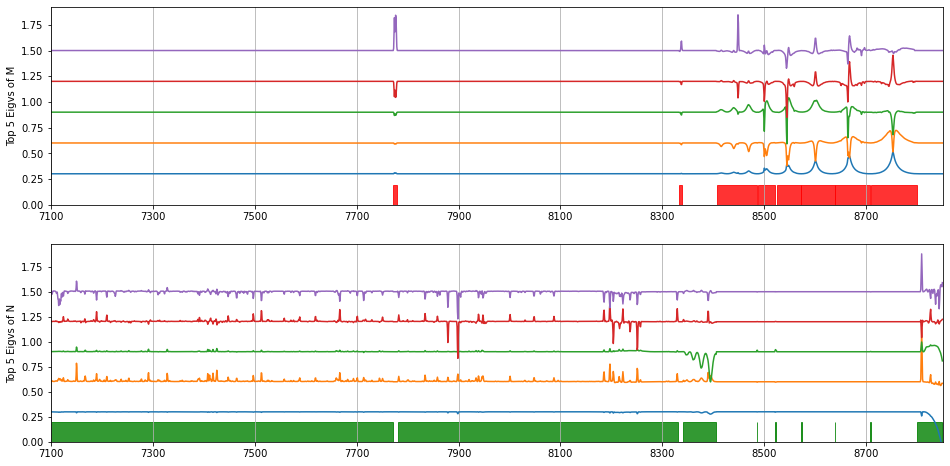

In [25]:
f, axs = plt.subplots(2,1,figsize=(16,8), facecolor="w")
ds.plot_MN(step=0.3, axs=axs)

In [111]:
ML, MS, MLv, MSv = ds._pcp(ds.M, delta=1e-6, mu=1.0/w[5], lam=None, norm=None, maxiter=1000)

mu 1.56, lambda 0.0174, norm 12809.7


1000


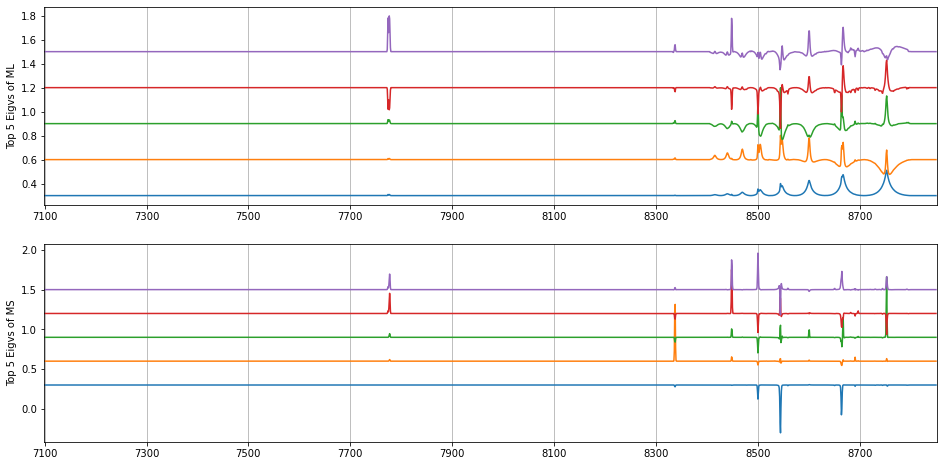

In [112]:
f, axs = plt.subplots(2,1,figsize=(16,8), facecolor="w")
ds.plot_eigv(MLv, name="ML", ax=axs[0])
ds.plot_eigv(MSv, name="MS", ax=axs[1])

In [ ]:
MLv.shape

In [114]:
NL, NS, NLv, NSv = ds._pcp(ds.N, delta=1e-6, mu=2.0, lam=None, norm=None, maxiter=1000)

mu 2.00, lambda 0.0174, norm 274.3


1000


In [115]:
NLv.shape

(209, 2204)

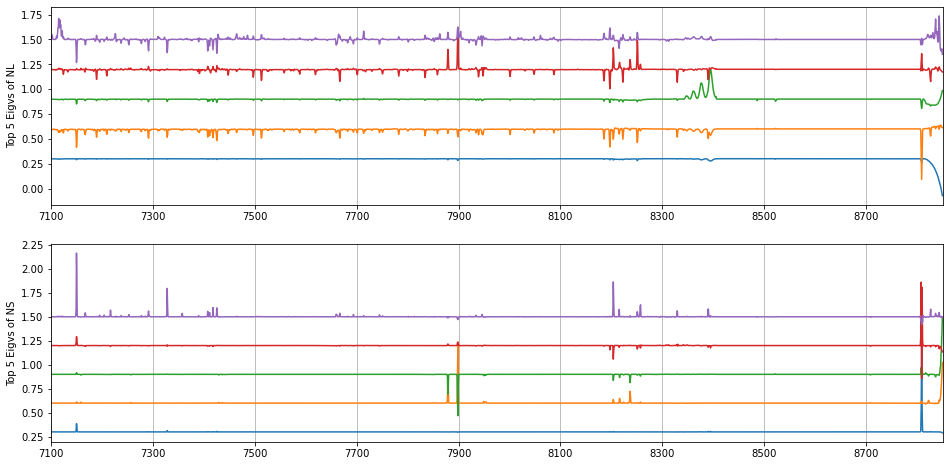

In [116]:
f, axs = plt.subplots(2,1,figsize=(16,8), facecolor="w")
ds.plot_eigv(NLv, name="NL", ax=axs[0])
ds.plot_eigv(NSv, name="NS", ax=axs[1])

In [117]:
ds.pcp_transform(MLv, MSv, NLv, NSv)

In [118]:
pcp20 = cp.vstack([MLv[:5],MSv,NLv[:5],NSv])

In [200]:
TRAIN_DIR = "/scratch/ceph/swei20/data/ae/"
TRAIN_PATH = os.path.join(TRAIN_DIR, "PCP_100k_BHB_RedM.h5")

In [226]:
ds.flux.shape

(3300, 2204)

In [196]:
TRAIN_PATH

'/scratch/ceph/swei20/data/ae/PCP_100k_BHB_RedM.h5'

In [203]:
with h5py.File(TRAIN_PATH, "r") as f:
    flux_t = f["flux"][()]
    wave_t = f["wave"][()]  
    para_t = f["pval"][()]        

In [1]:
LOAD_PATH = "/scratch/ceph/swei20/data/ae/PCP_1k_BHB_RedM.h5"

In [2]:
with h5py.File(TRAIN_PATH, "r") as f:
    flux_tt = f["flux"][()]
    pval = f["pval"][()]        

NameError: name 'h5py' is not defined

In [204]:
flux_t.shape

(100000, 2204)

In [205]:
pcp20n = cp.asnumpy(pcp20)

In [208]:
flux_t20 = np.dot(flux_t, pcp20n.T)

In [209]:
flux_t20.shape

(100000, 20)

In [213]:
para_t.shape

(100000, 5)

In [ ]:
TRAIN_DIR = "/scratch/ceph/swei20/data/ae/"
TRAIN_PATH = os.path.join(TRAIN_DIR, "DNN_BHB_RedM.h5")

In [ ]:
with h5py.File(TRAIN_PATH, 'w') as f:
    f.create_dataset('flux', data = flux_t20, shape=flux_t20.shape)
    f.create_dataset('RBF_PATH', data = RBF_PATH)
    f.create_dataset('para', data = para_t, shape=para_t.shape)

In [216]:
from matplotlib import cm

In [218]:
para_t[:,1].shape

(100000,)

Text(0.5, 1.0, 'BlueHB in RedM R=5000 from RBF')

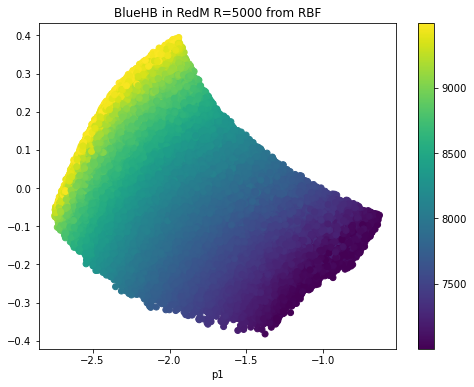

In [225]:
plt.figure(figsize=(8,6), facecolor="w")
plt.scatter(flux_t20[:,0], flux_t20[:,1], c =para_t[:,1] )
plt.colorbar()
plt.xlabel("p0")
plt.xlabel("p1")
plt.title("BlueHB in RedM R=5000 from RBF")

In [ ]:
SAVE_PATH = 

In [ ]:
with h5py.File(SAVE_PATH, 'w') as f:
    f.create_dataset('PC', data = train_pc, shape=train_pc.shape)
    f.create_dataset('RBF_PATH', data = RBF_PATH)
    f.create_dataset('eigv', data = rbf.grid.eigv['flux'])

In [192]:
MLv.shape

(239, 2204)

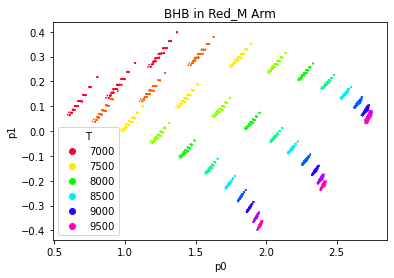

In [185]:
ds.p(0,1,"T",large=0)

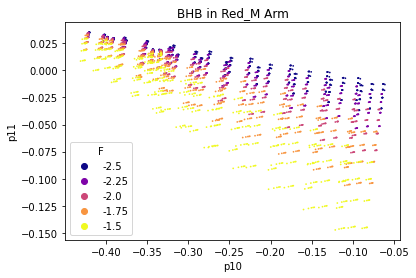

In [186]:
ds.p(10,11,"F")

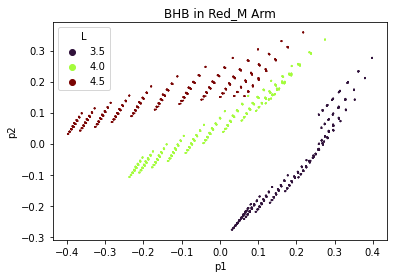

In [187]:
ds.p(1,2,"L")

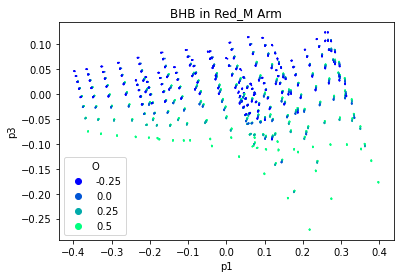

In [188]:
ds.p(1,3,"O")

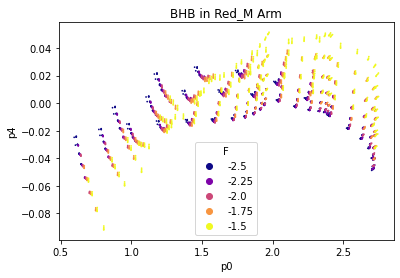

In [189]:
ds.p(0,4,"F")

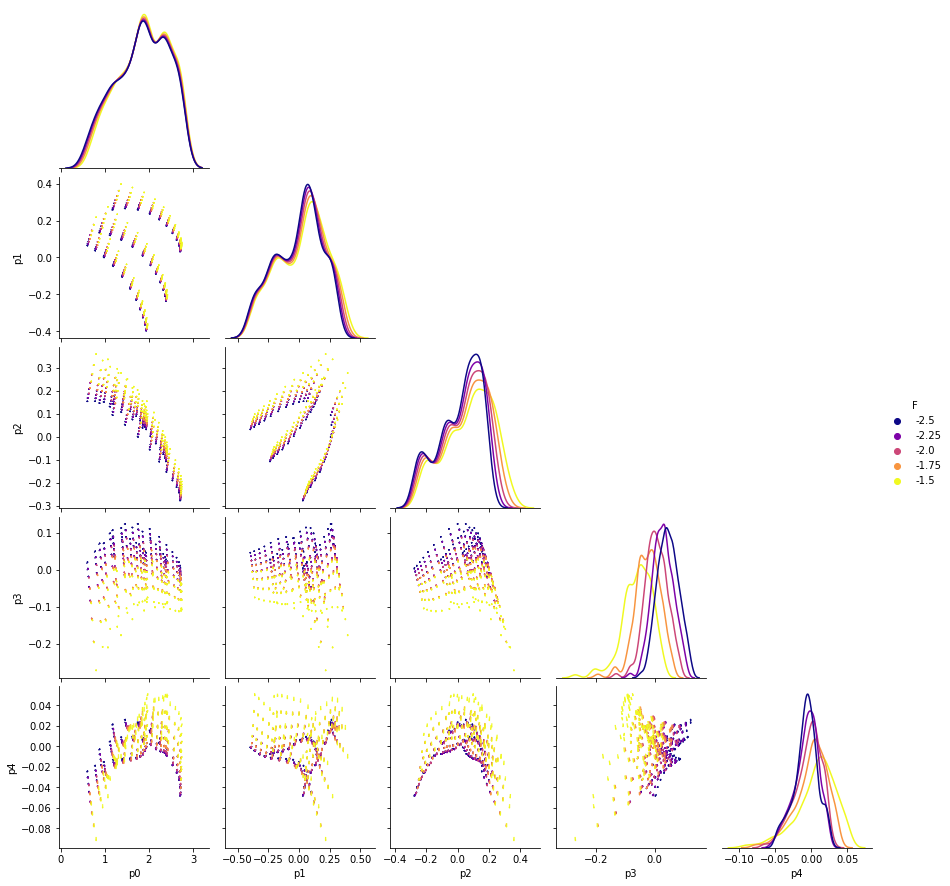

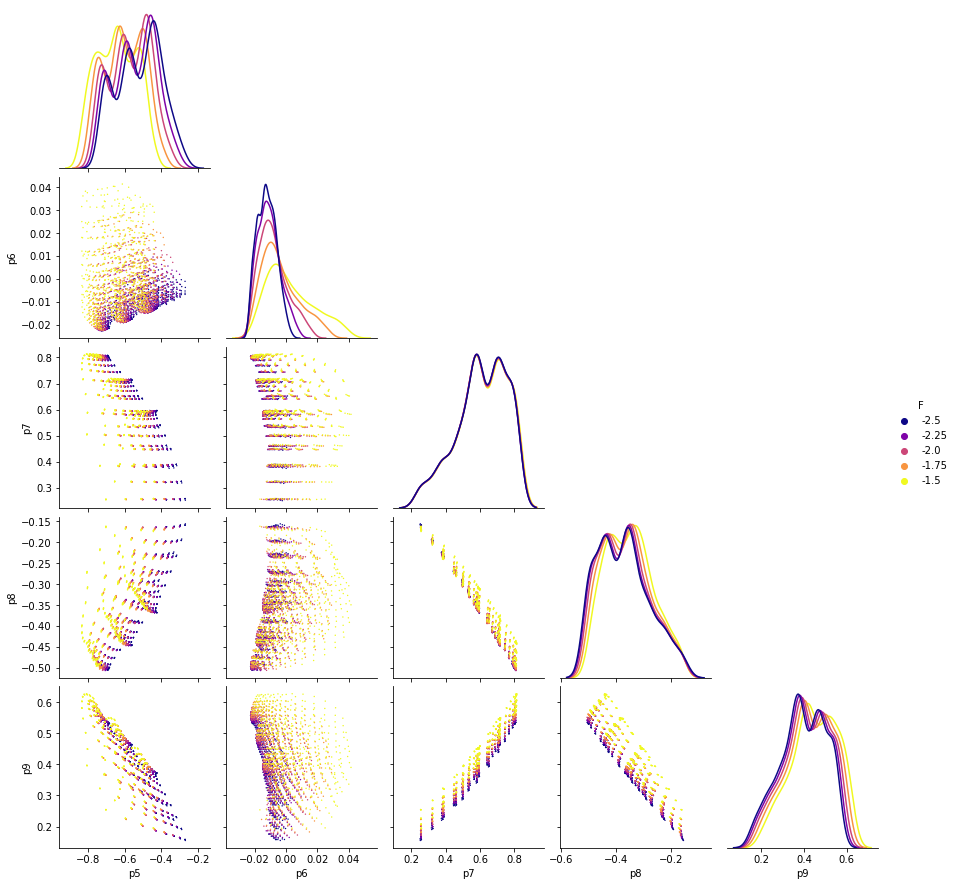

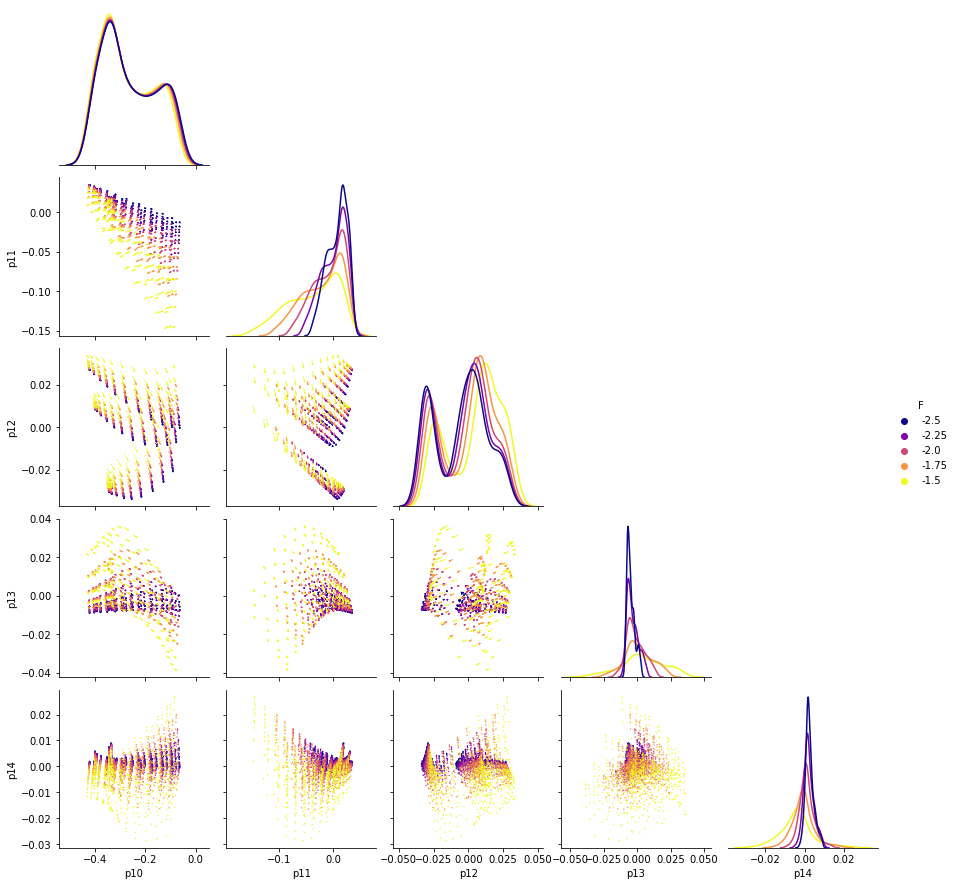

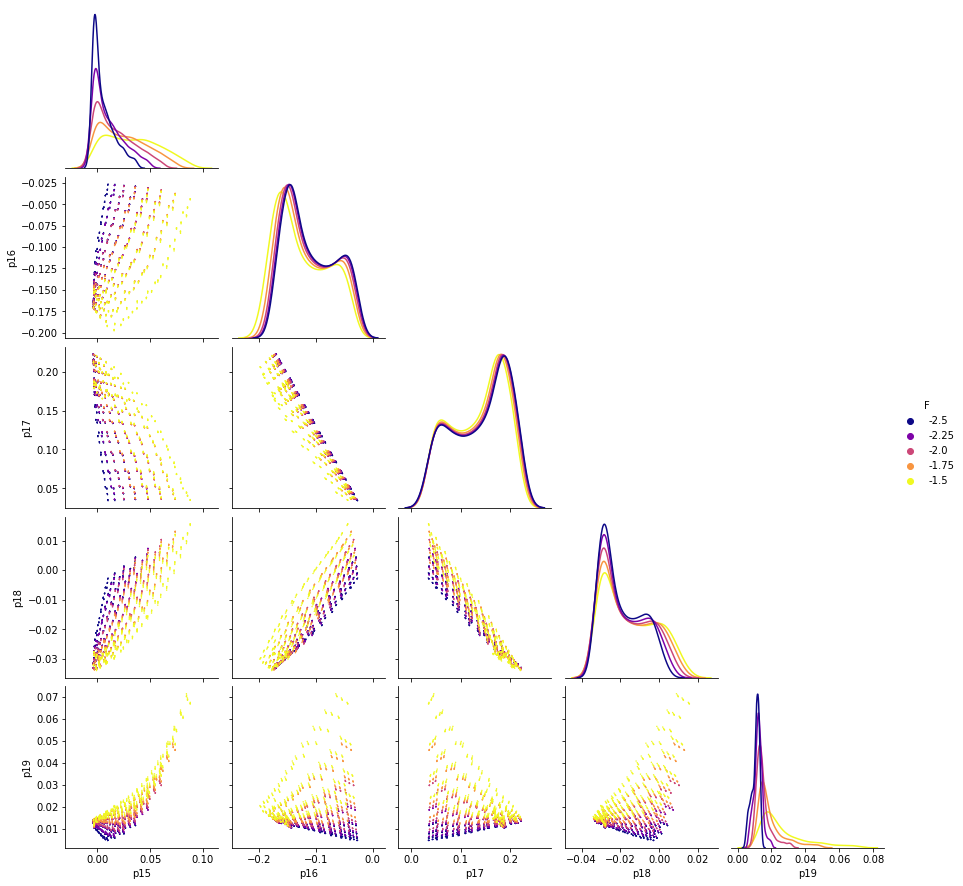

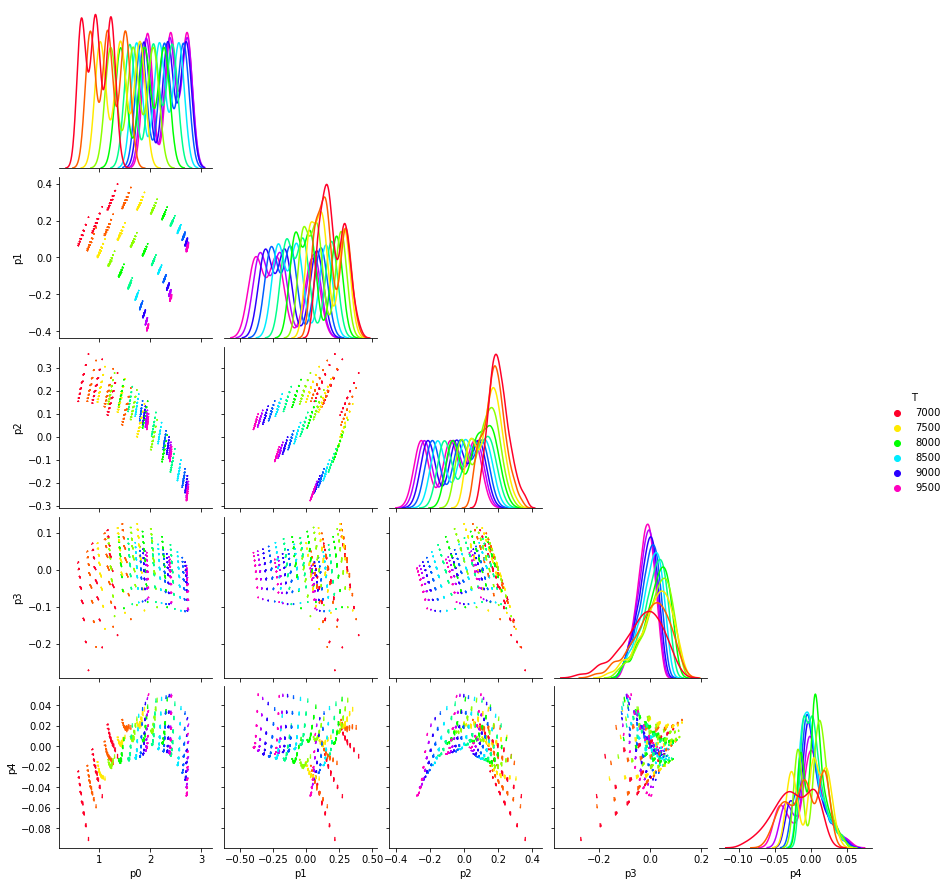

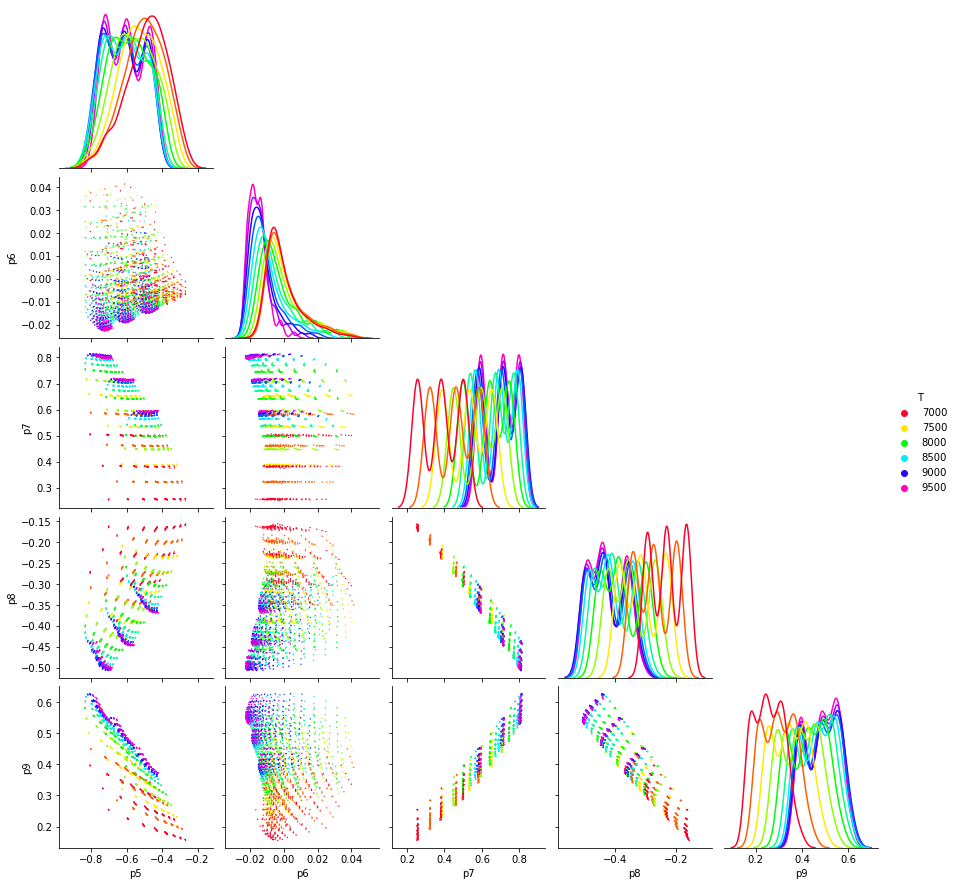

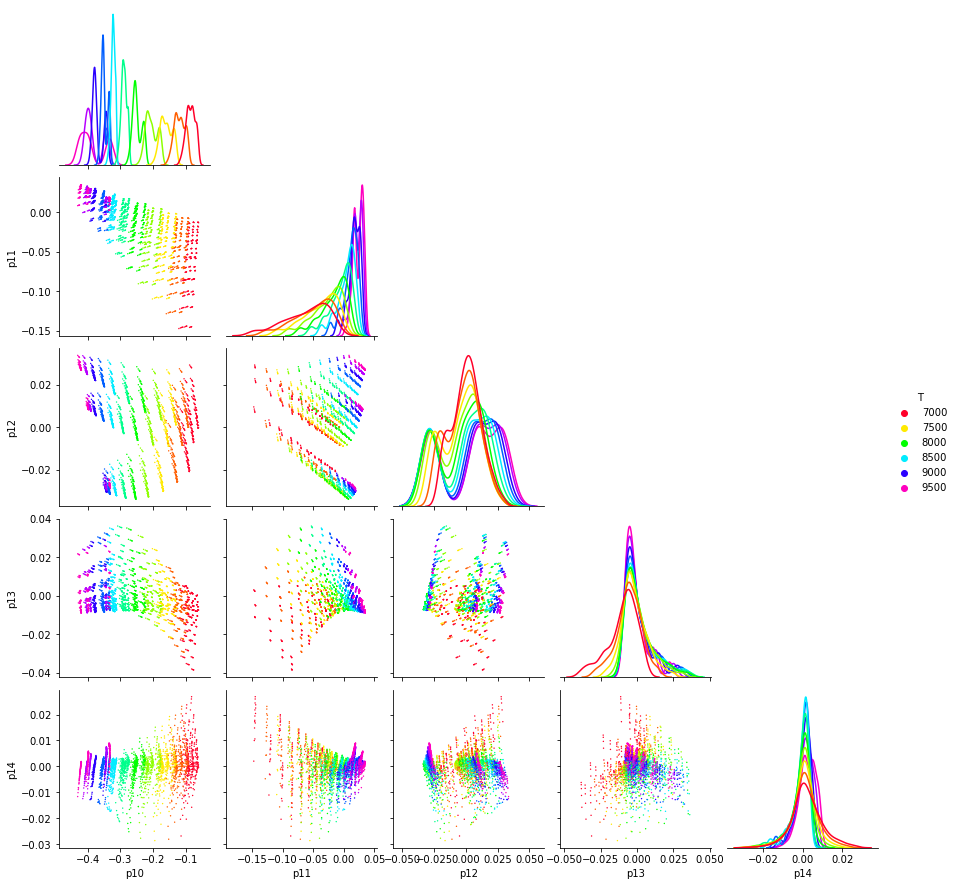

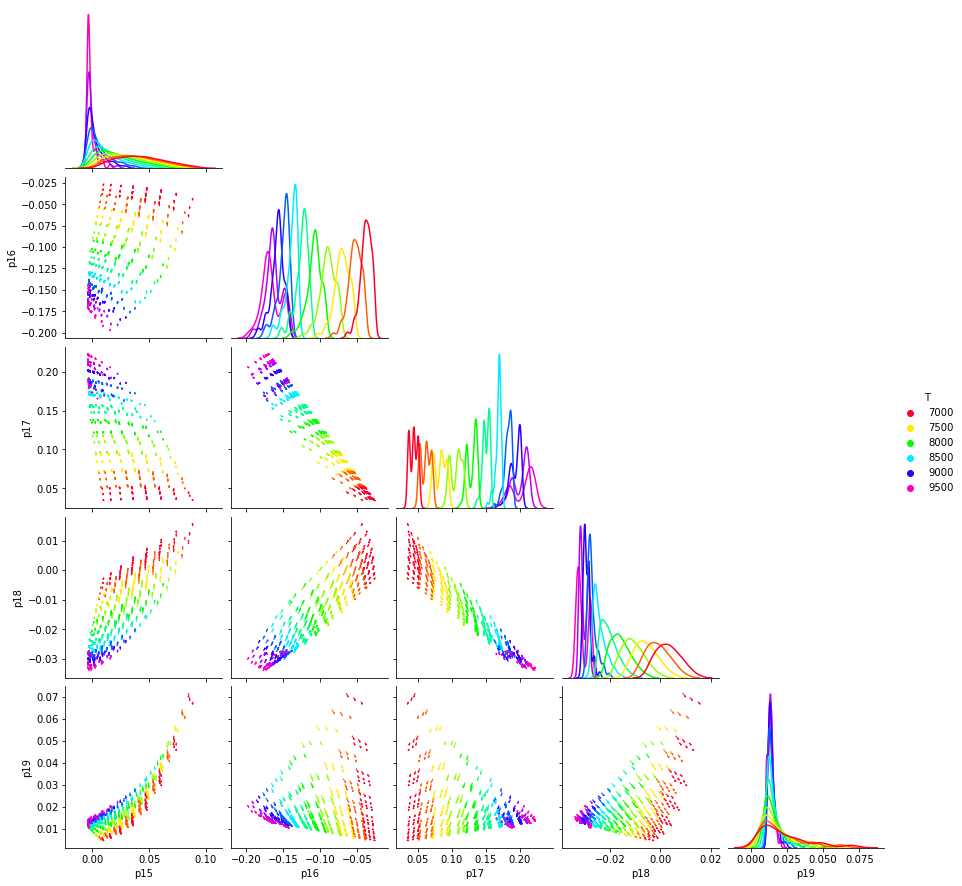

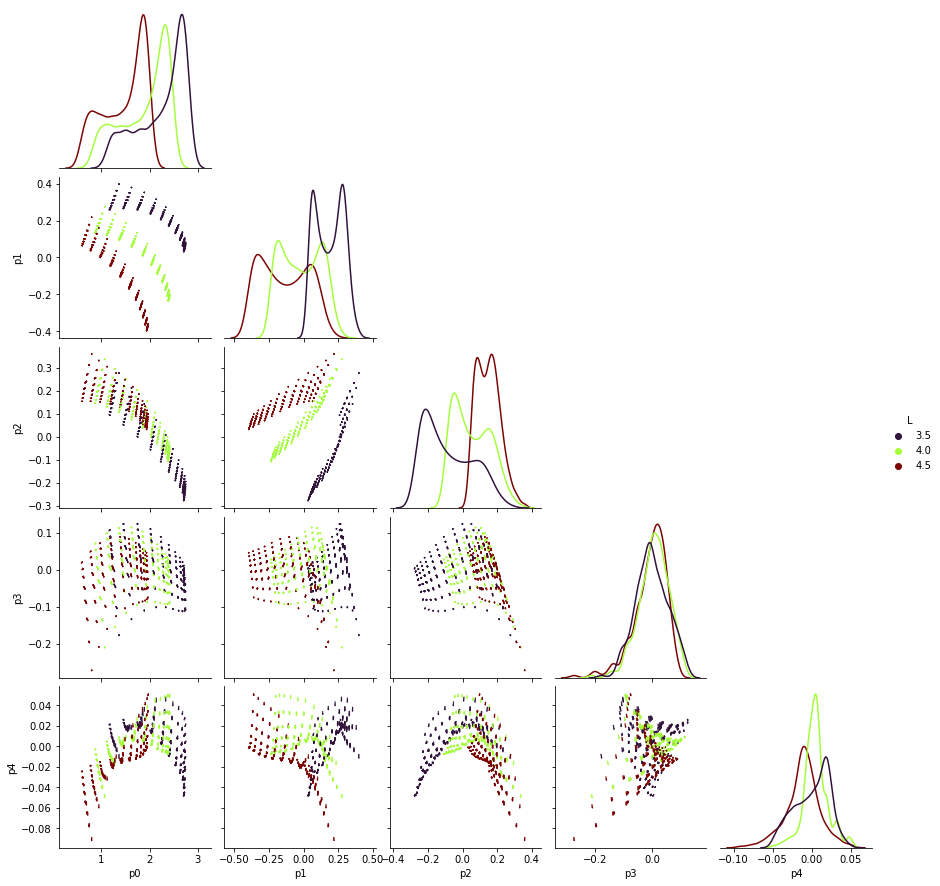

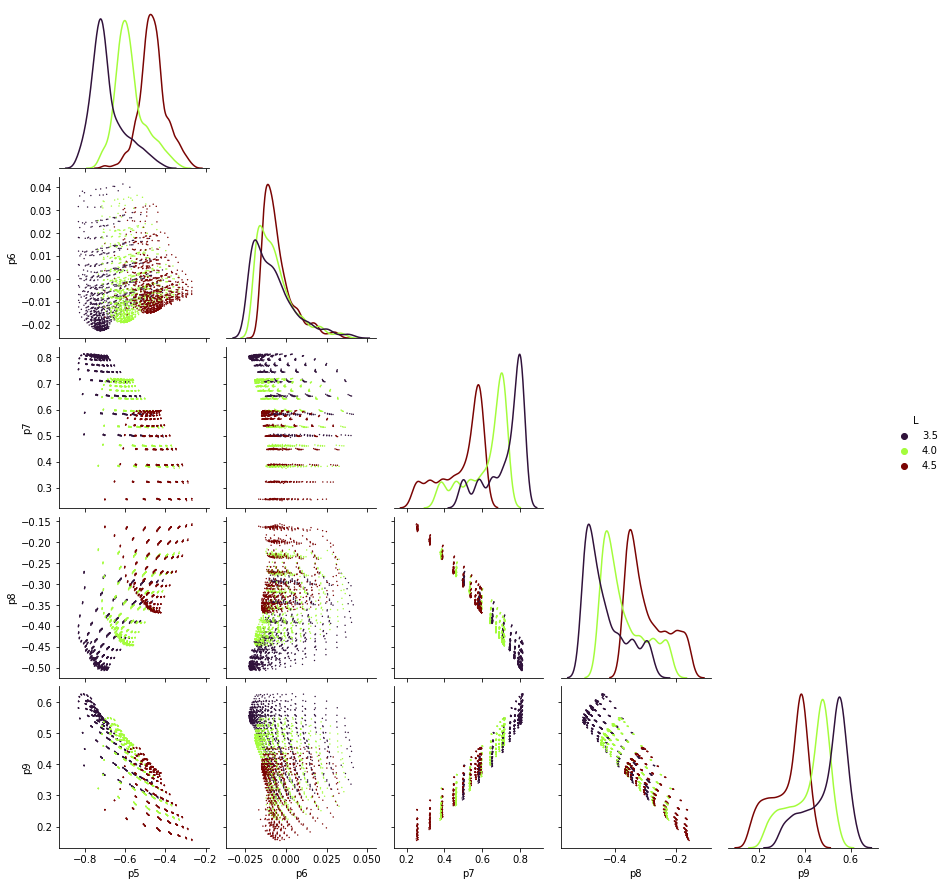

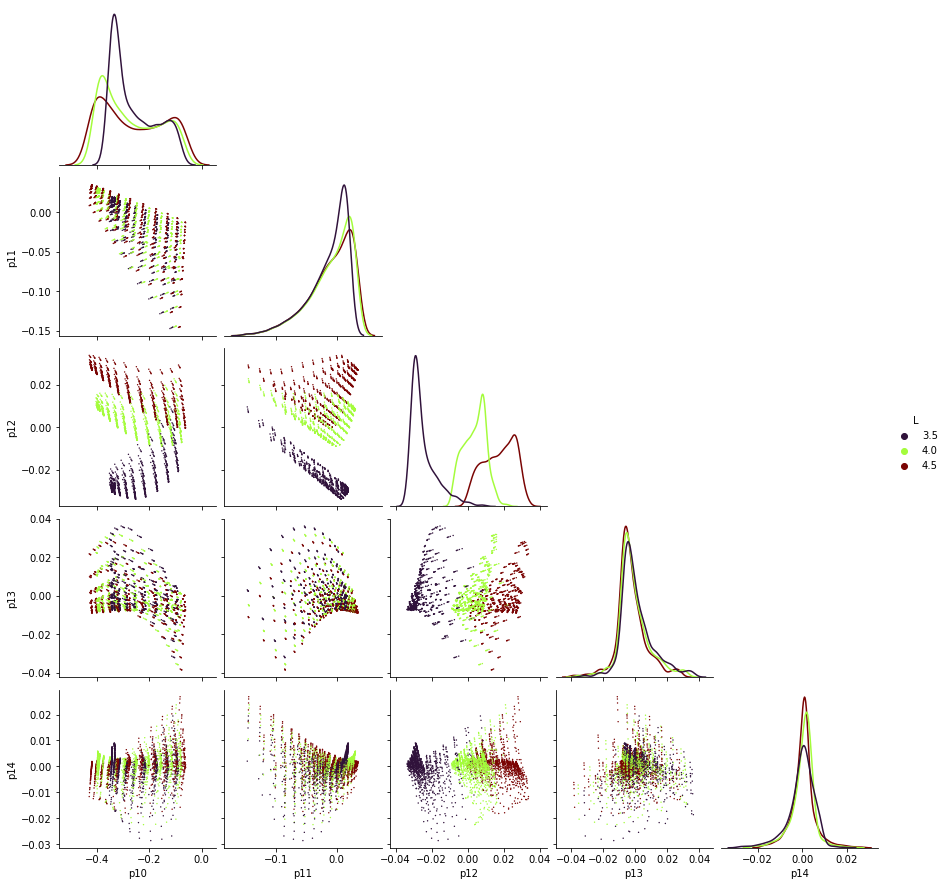

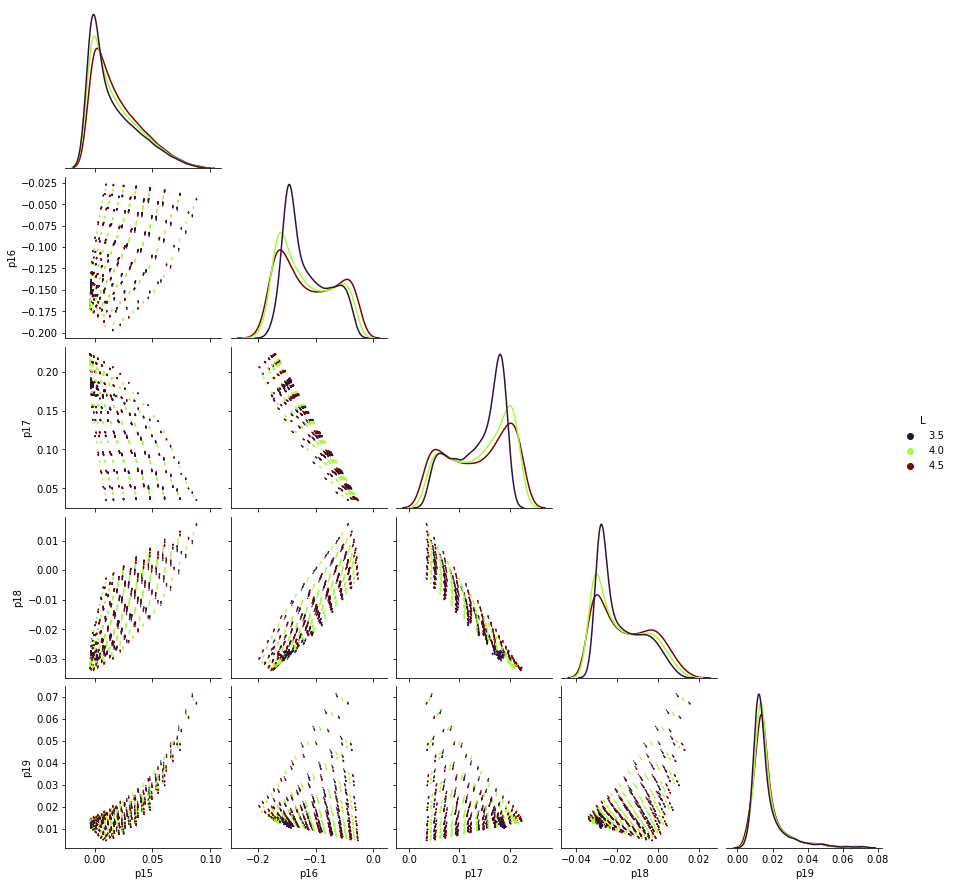

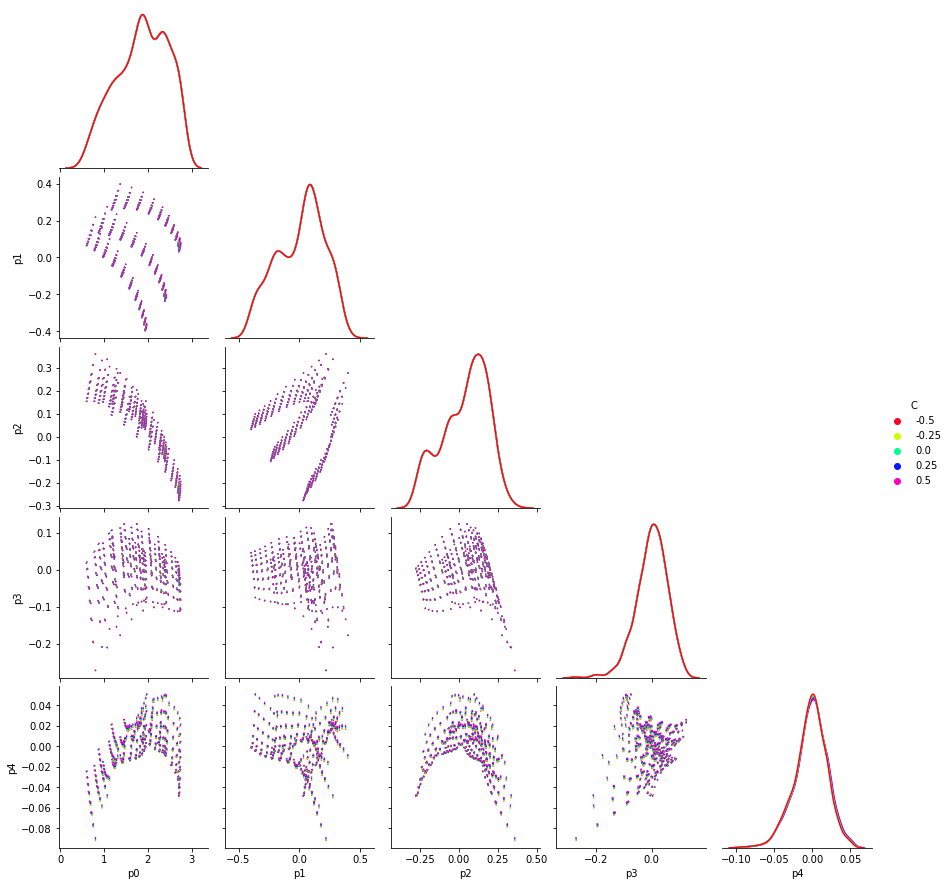

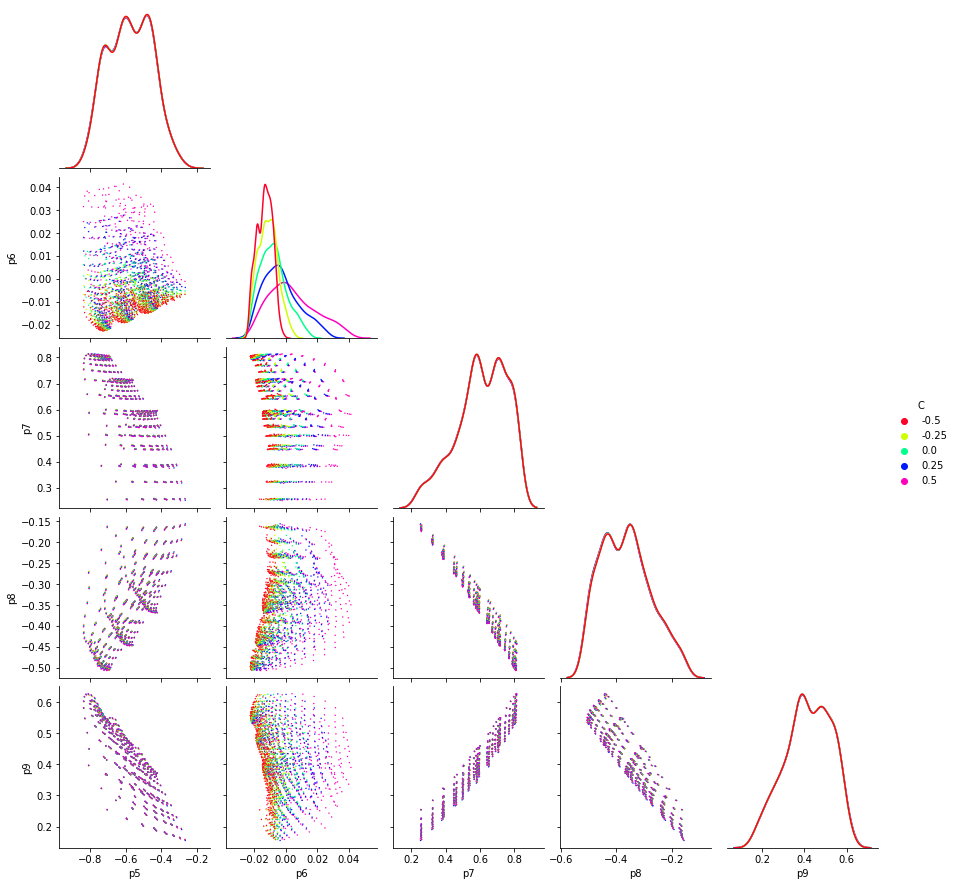

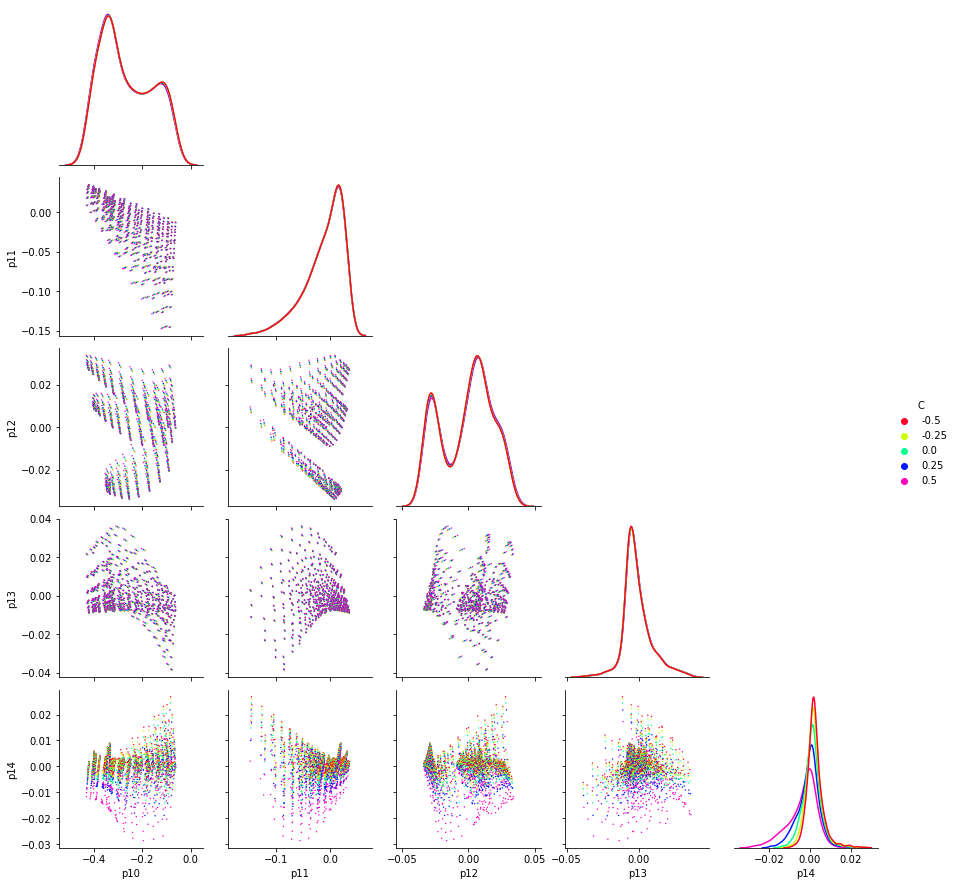

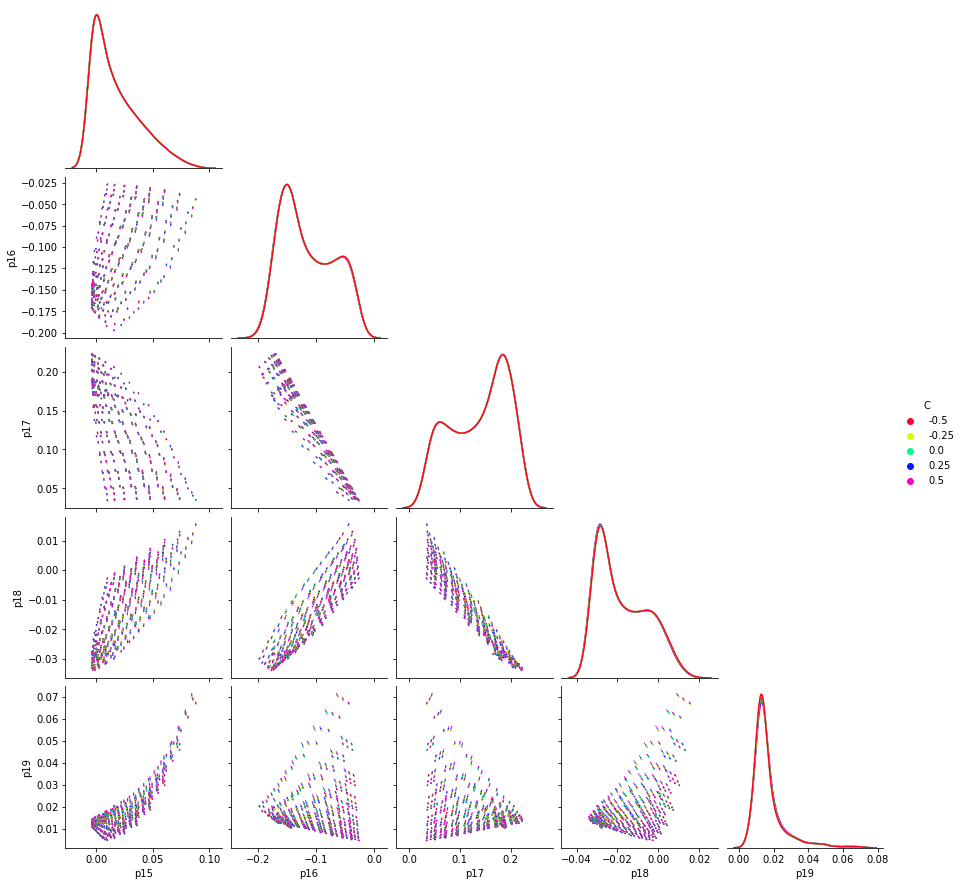

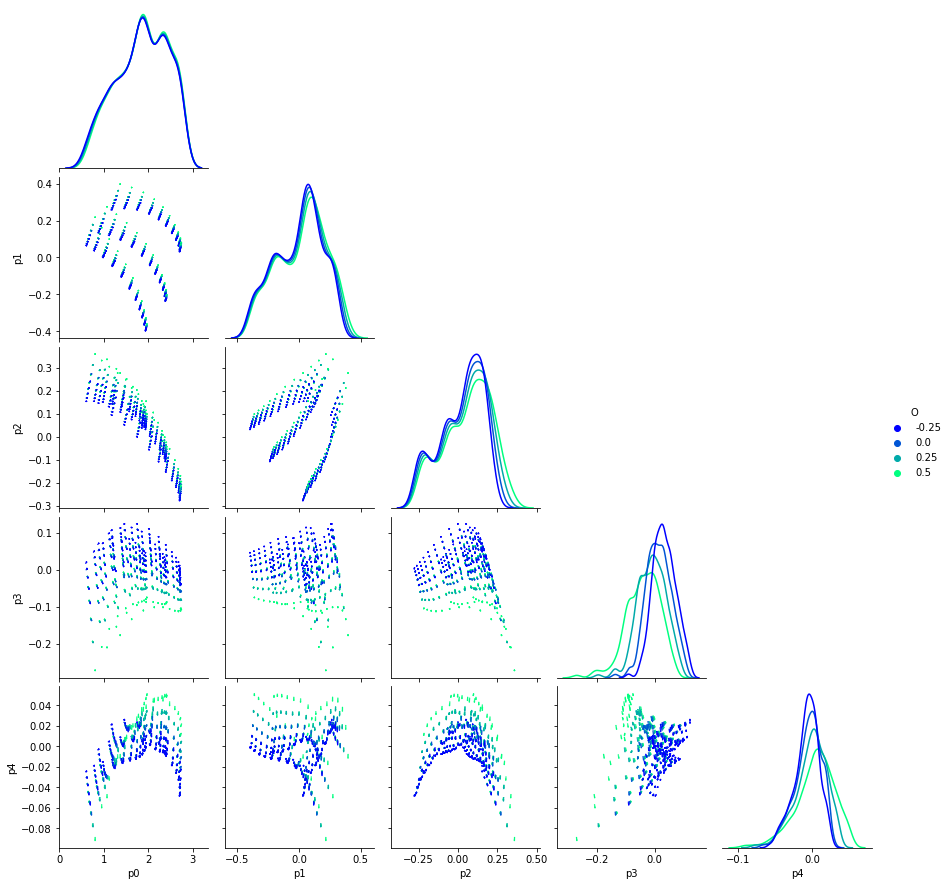

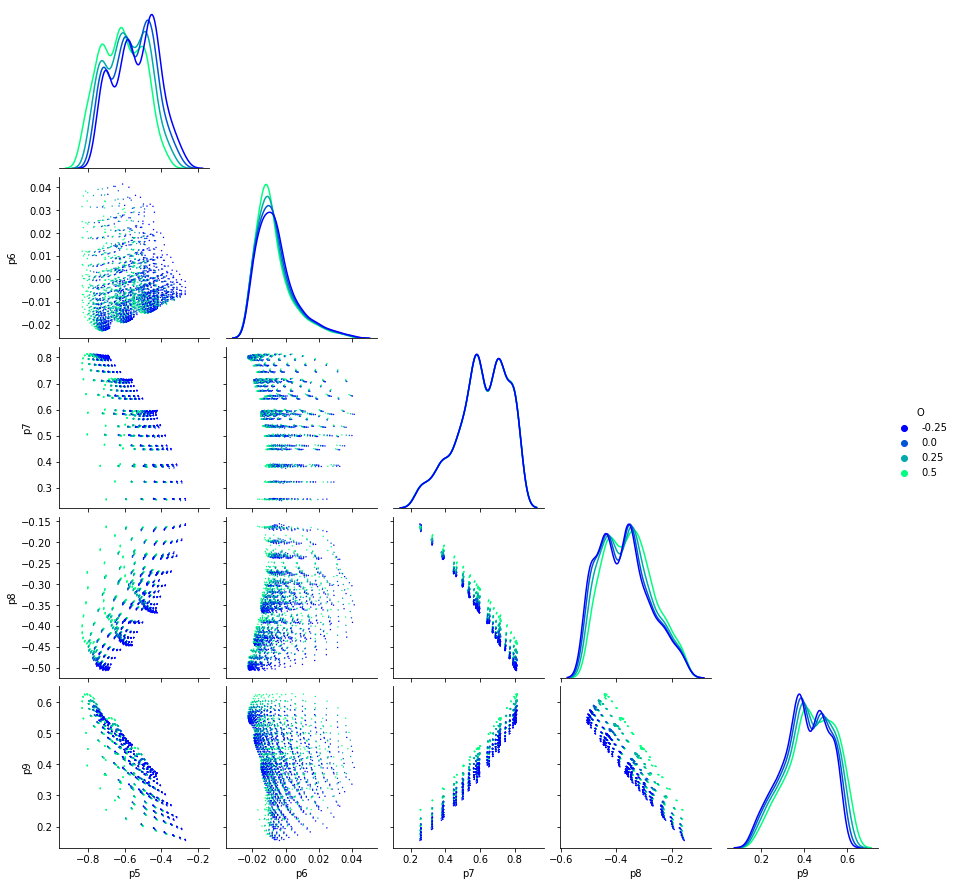

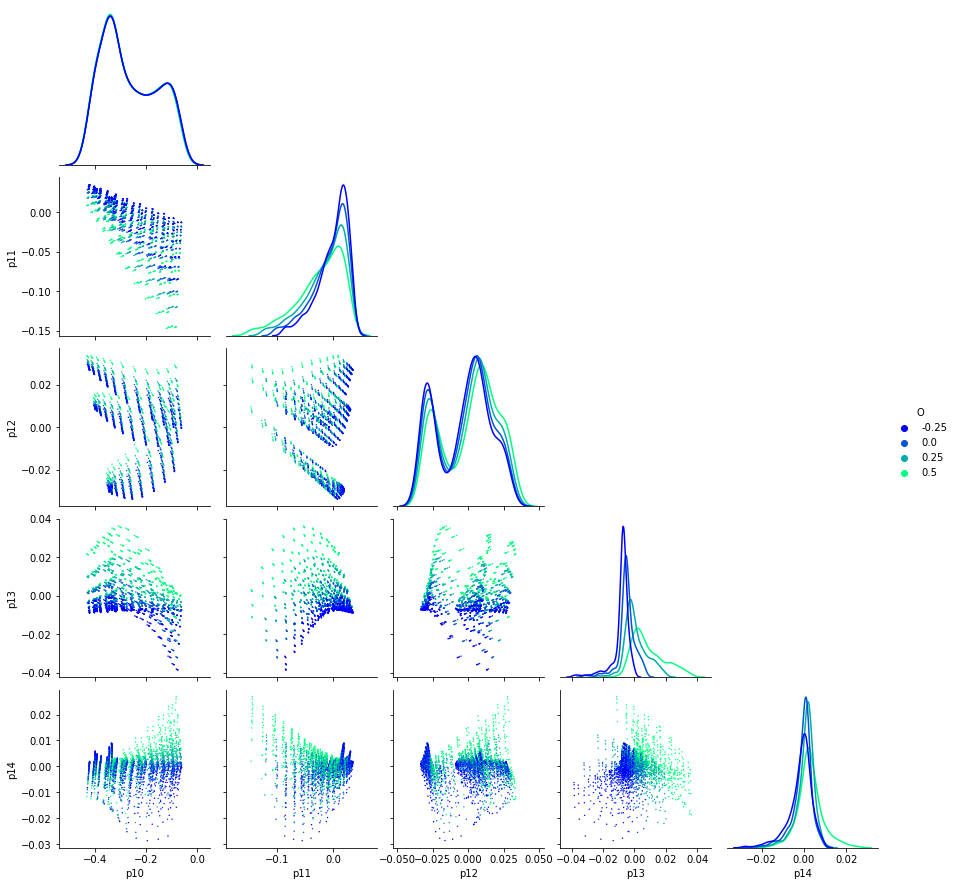

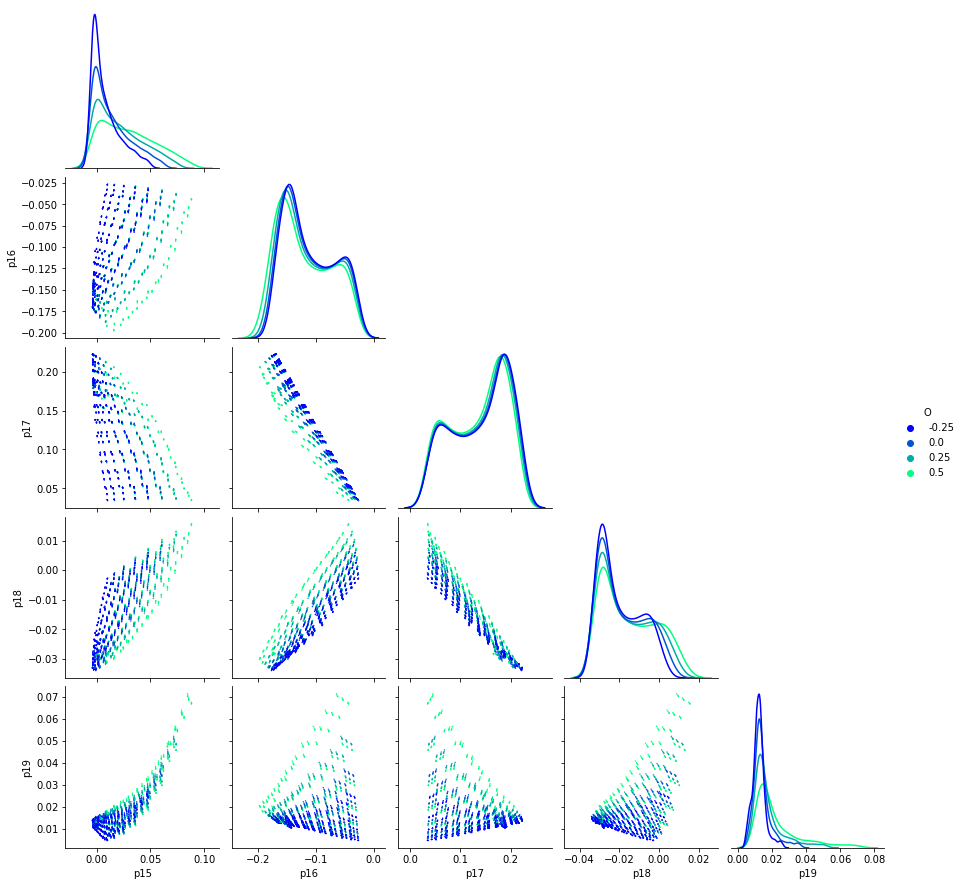

In [190]:
for p in ["F","T","L","C","O"]:
    for i in range(4):
        ds.pp(i, p)

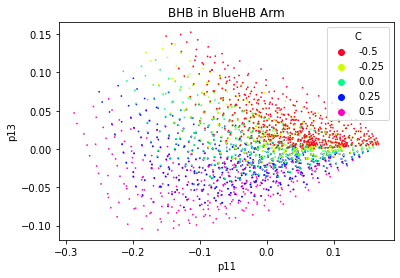

In [124]:
ds.p(11,13,"C")

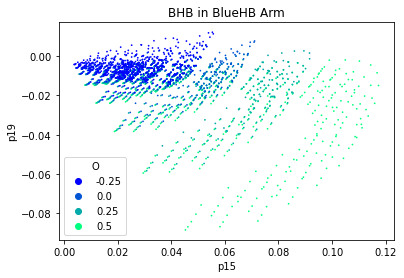

In [125]:
ds.p(15,19,"O")

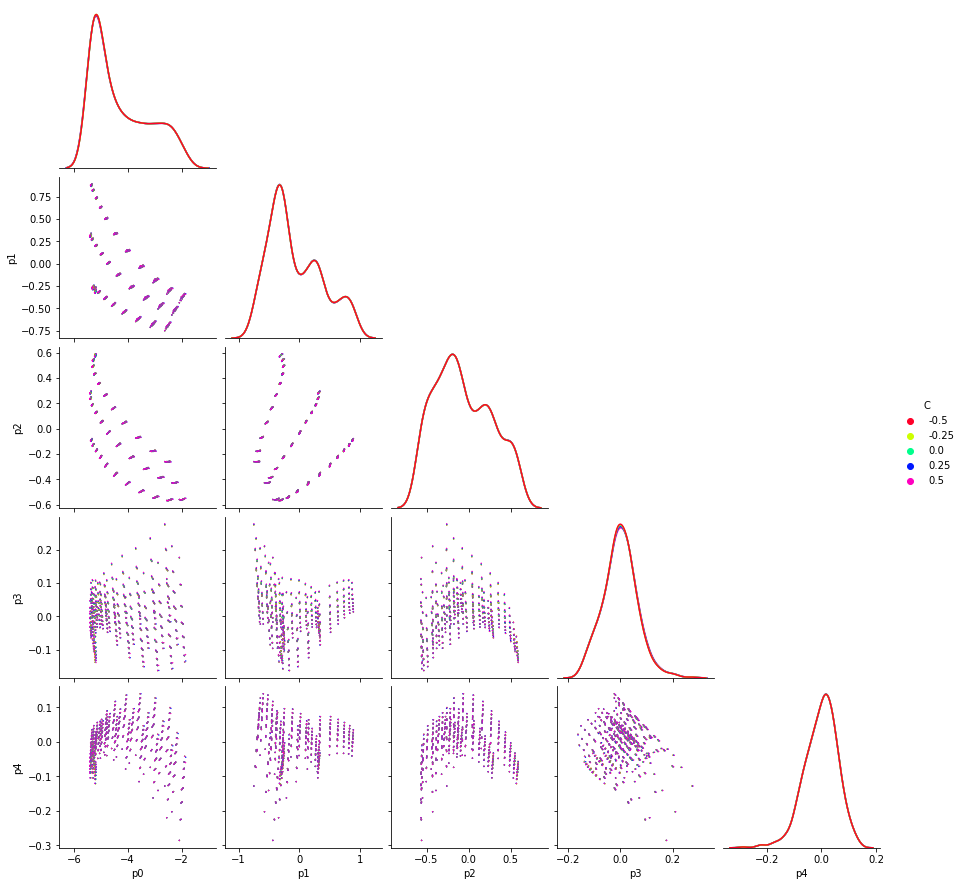

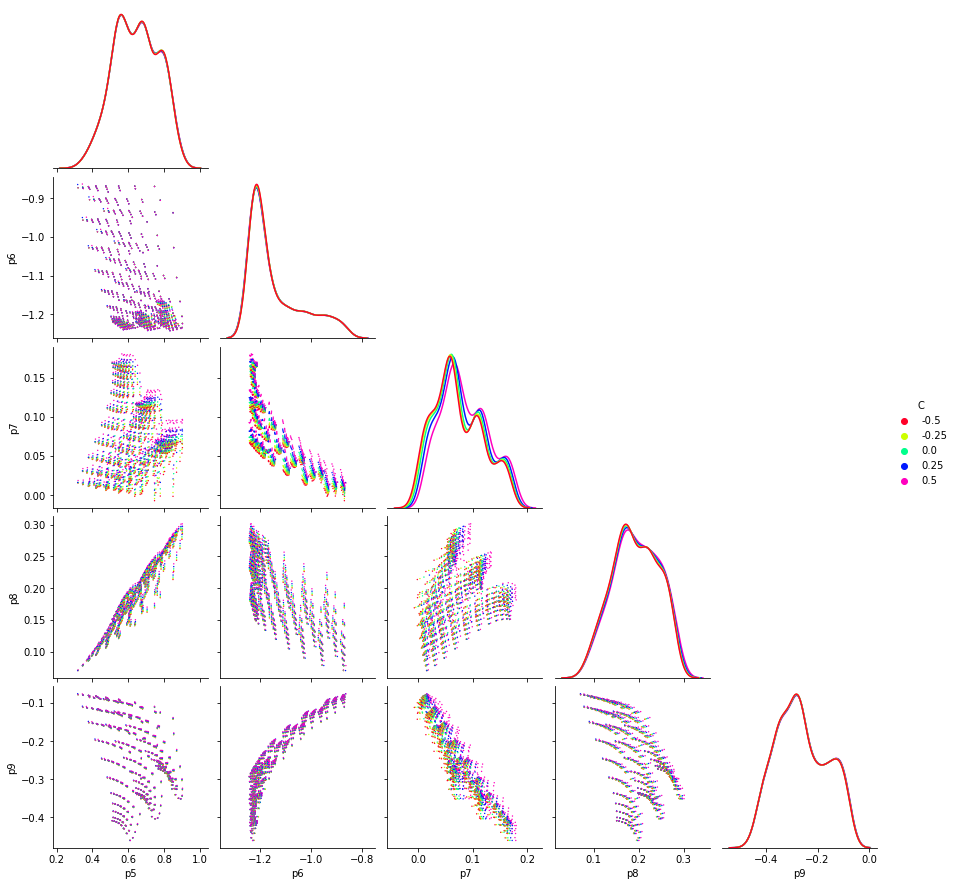

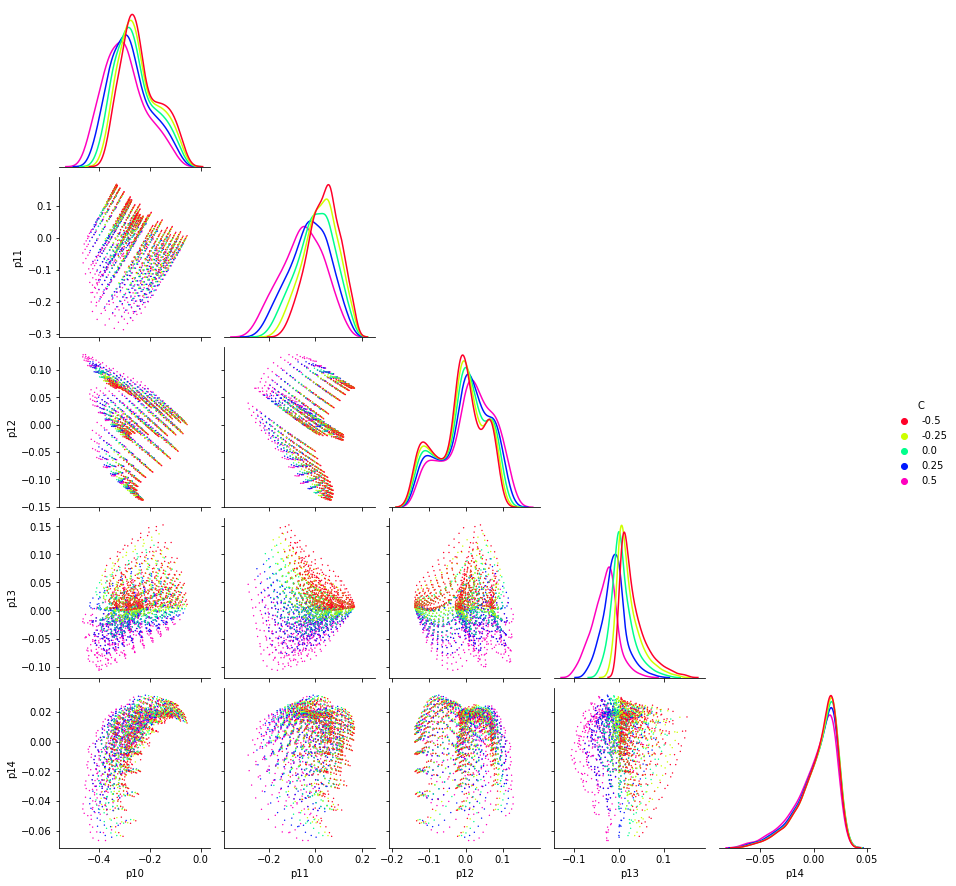

In [118]:
for i in range(3):
    ds.pp(i,"C")

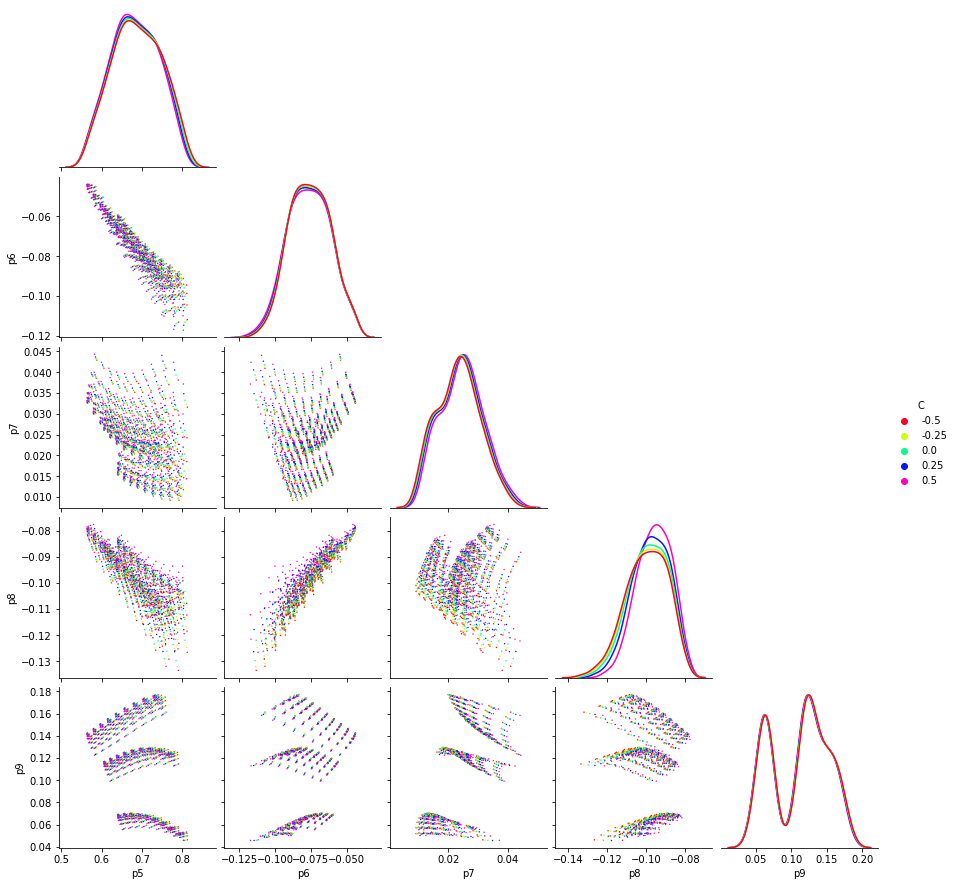

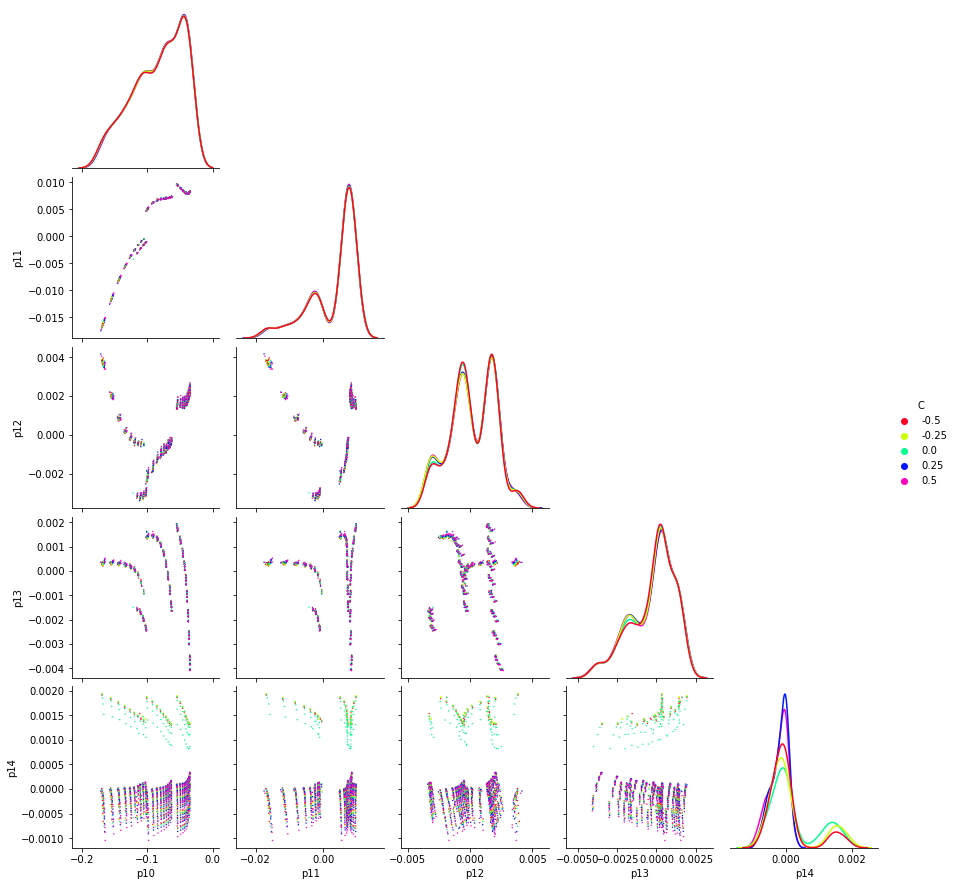

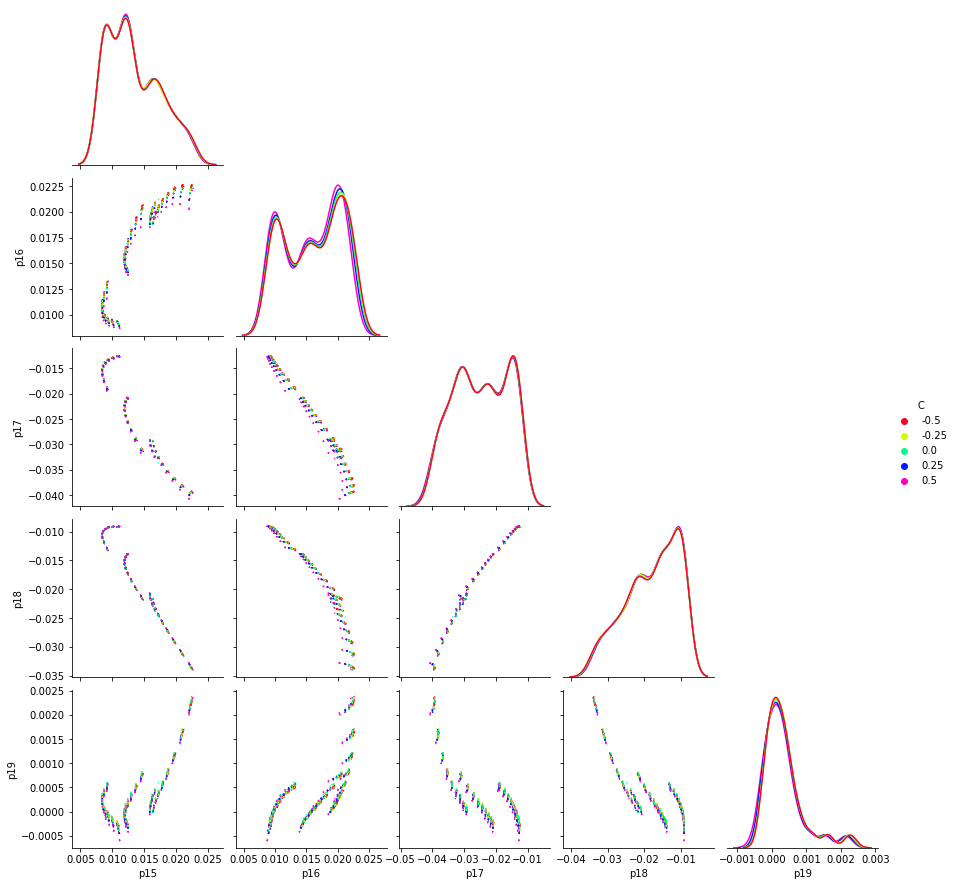

In [29]:
for i in range(1,4):
    ds.pp(i,"C")    

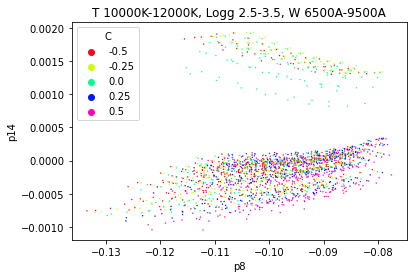

In [30]:
ds.p(8,14,"C")

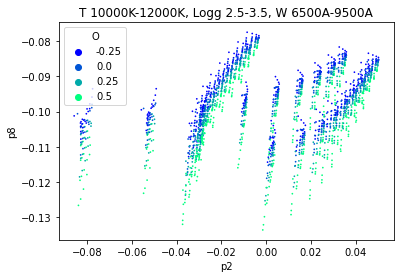

In [44]:
ds.p(2,8,"O")